In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

plt.rcParams["font.size"]=18

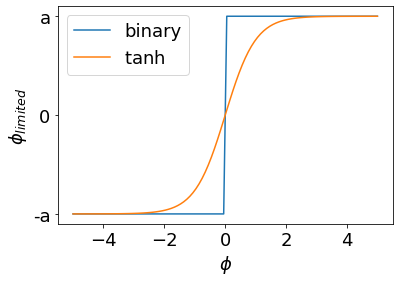

In [6]:
x = np.linspace(-5, 5, 100)
tanh = tf.tanh(x)
bi = np.where(x>=0, 1, -1)

plt.plot(x, bi, label="binary")
plt.plot(x, tanh, label=r'$\tanh$')

plt.yticks([-1, 0, 1], ["-a", "0", "a"])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\phi_{limited}$')
plt.legend()